<a href="https://colab.research.google.com/github/AndreyBocharnikov/Recommendation-systems/blob/master/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

dir_name = '/content/drive/My Drive/itmo/RecSys/datasets/kkbox-music-recommendation-challenge'

Mounted at /content/drive/


In [2]:
!pip install xgboost

In [3]:
!pip install catboost

     |████████████████████████████████| 67.3MB 76kB/s 


In [4]:
!pip install shap

     |████████████████████████████████| 358kB 10.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491633 sha256=c324e6649790c2282ac742a8c4cb63625c96c4537e46e7406958fe1ba3de6289
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import time
import copy
import itertools
from sklearn.model_selection import KFold
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
import shap

Загрузим данные и посмотрим на них

In [3]:
train = pd.read_csv(os.path.join(dir_name, "train.csv"))
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
train.shape, train.msno.nunique(), train.song_id.nunique()

((7377418, 6), 30755, 359966)

In [5]:
songs = pd.read_csv(os.path.join(dir_name, "songs.csv"))
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
songs.shape

(2296320, 7)

In [7]:
songs.isna().mean() # композитор и слова песни слишком часто Nan чтобы их не дропнуть

song_id        0.000000e+00
song_length    0.000000e+00
genre_ids      4.098558e-02
artist_name    0.000000e+00
composer       4.665526e-01
lyricist       8.471241e-01
language       4.354794e-07
dtype: float64

In [8]:
songs.language.value_counts()

 52.0    1336694
-1.0      639467
 3.0      106295
 17.0      92518
 24.0      41744
 31.0      39201
 10.0      15482
 45.0      14435
 59.0       8098
 38.0       2385
Name: language, dtype: int64

In [ ]:
members = pd.read_csv(os.path.join(dir_name, "members.csv"))
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
members.shape

(34403, 7)

In [ ]:
test = pd.read_csv(os.path.join(dir_name, "test.csv"))
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


Предобрадотаем информацию о песнях

In [9]:
songs.isna().sum(axis=0)

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

In [10]:
songs_usefull = songs.drop(labels=['composer', 'lyricist'], axis='columns')

In [11]:
songs_usefull.language.unique()

array([ 3., 31., 52., 17., 10., -1., 24., 59., 45., 38., nan])

In [12]:
songs_usefull.language.fillna(value=-1, inplace=True)

In [13]:
songs_usefull.genre_ids.unique()

array(['465', '444', '726', ..., '786|958|2022', '1259|2107', '1138|2022'],
      dtype=object)

In [14]:
songs_usefull.genre_ids = songs_usefull.genre_ids.apply(lambda x: x.split('|') if type(x) == str else [])

In [15]:
songs_usefull.head()

,song_id,song_length,genre_ids,artist_name,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,[465],張信哲 (Jeff Chang),3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,[444],BLACKPINK,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,[465],SUPER JUNIOR,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,[465],S.H.E,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,[726],貴族精選,52.0


In [16]:
songs_usefull.isna().sum(axis=0)

song_id        0
song_length    0
genre_ids      0
artist_name    0
language       0
dtype: int64

In [17]:
del songs

Предобработает тренировочные данные

In [18]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [19]:
train.isna().mean(axis=0)

msno                  0.000000
song_id               0.000000
source_system_tab     0.003368
source_screen_name    0.056226
source_type           0.002920
target                0.000000
dtype: float64

In [20]:
train.drop(labels=['source_system_tab', 'source_screen_name', 'source_type'], axis='columns', inplace=True)

Сделаем данные для обучения

In [21]:
df = train.merge(songs_usefull, on='song_id', how='inner')
df.isna().sum(axis=0)

msno           0
song_id        0
target         0
song_length    0
genre_ids      0
artist_name    0
language       0
dtype: int64

In [22]:
df.head()

,msno,song_id,target,song_length,genre_ids,artist_name,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,206471,[359],Bastille,52.0
1,e5Ezre9HPuPos+CXQXtmo32E/hHIZTMmo6jG3yRf6UA=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,206471,[359],Bastille,52.0
2,pouJqjNRmZOnRNzzMWWkamTKkIGHyvhl/jo4HgbncnM=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,206471,[359],Bastille,52.0
3,sSexP400TJOZRhx3JB+0s9cqrCnqrlV51B9njoKR1II=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,206471,[359],Bastille,52.0
4,hKdGiUKHVqKkXGHLrc+EzdSW6q0ERAJ2Cs7/L1N0Ae4=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,0,206471,[359],Bastille,52.0


In [49]:
# вспомогательная функция чтобы преобразовать genre1|genre2|genre3 в 3 отдельные строки dataframe'а с соотв. жанрами
def split_genres(train_df):
  new_rows = []
  for index, row in train_df.iterrows():
    rows_copy = [copy.deepcopy(row) for _ in row.genre_ids]
    for i, row in enumerate(rows_copy):
      row.genre_ids = row.genre_ids[i]
    new_rows += rows_copy
  return pd.DataFrame.from_records(new_rows)

In [50]:
# предпочтения пользователей по жанрам - для каждого пользователя считается распределение по жанрам и сколько каждого из них он слушал
def make_genres_features(train_df):
  single_genre = train_df[train_df.genre_ids.str.len() == 1].copy()
  single_genre.genre_ids = single_genre.genre_ids.apply(lambda x: x[0])
  train_df = split_genres(train_df[train_df.genre_ids.str.len() > 1])
  train_df = train_df.append(single_genre, ignore_index=True)
  
  user_genres = train_df.groupby(["msno", "genre_ids"])
  user_genres_pos = user_genres.target.sum()
  user_genres_mean = user_genres.target.mean()
  return user_genres_pos, user_genres_mean

In [51]:
# фичи связанные с языком - распределение по языкам для каждого пользователя и сколько в абсолютной величине он слушал песен на каждом языке
def make_language_features(train_df):
  user_language = train_df.groupby(["msno", "language"])
  user_language_sum = user_language.target.sum()
  user_language_mean = user_language.target.mean()
  return user_language_sum, user_language_mean

In [52]:
# средняя продолжительность песен которые слушал пользователь
def make_duration_features(train_df):
  return train_df[train_df.target == 1].groupby('msno').song_length.mean()

In [53]:
# строиться распределение исполнителей для каждого пользователя
def make_artist_features(train_df):
  user_artist_cnt = train_df.groupby(['msno', 'artist_name']).size()
  n_user_listenings = train_df.groupby('msno').size()
  return user_artist_cnt / n_user_listenings

In [54]:
# основная функция для создания фичей
def make_features(train_df):
  user_genres_sum, user_genres_mean = make_genres_features(train_df)
  user_language_sum, user_language_mean = make_language_features(train_df)
  mean_dur_of_pos_songs = make_duration_features(train_df)
  user_artist_prob = make_artist_features(train_df)
  return user_genres_sum, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob

In [55]:
def transform_features(df, user_genres_sum, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob):
  rev_index = {index: i for i, index in enumerate(user_genres_sum.index)} # брать .iloc[key_to_index_dict.get(key)] быстрее чем аналогичный .loc[key]
  rev_index2 = {index: i for i, index in enumerate(user_genres_mean.index)}
  rev_index3 = {index: i for i, index in enumerate(user_language_sum.index)}
  rev_index4 = {index: i for i, index in enumerate(user_language_mean.index)}
  rev_index5 = {index: i for i, index in enumerate(mean_dur_of_pos_songs.index)}
  rev_index6 = {index: i for i, index in enumerate(user_artist_prob.index)}
  
  
  user_genres_mean_sum_features = []
  user_genres_mean_mean_features = []
  user_genres_max_sum_features = []
  user_genres_max_mean_features = []
  user_language_sum_features = []
  user_language_mean_features = []
  user_dur_features = []
  user_artist_features = []

  
  for index, row in df.iterrows():
    msno = row.msno
    language = row.language
    # 2 способа агрегировать жанры: усреднение и максимум
    genre_mean_sum = 0
    genre_mean_mean = 0
    genre_max_sum = 0
    genre_max_mean = 0
    for genre in row.genre_ids:
      sum_ = user_genres_sum.iloc[rev_index.get((msno, genre), 0)]
      mean_ =  user_genres_mean.iloc[rev_index2.get((msno, genre), 0)]
      genre_mean_sum += sum_
      genre_mean_mean += mean_
      genre_max_sum = max(genre_max_sum, sum_)
      genre_max_mean = max(genre_max_mean, mean_)
      
    n_genres = len(row.genre_ids)
    if n_genres != 0:
      genre_mean_sum /= n_genres
      genre_mean_mean /= n_genres
    user_genres_mean_sum_features.append(genre_mean_sum)
    user_genres_mean_mean_features.append(genre_mean_mean)
    user_genres_max_sum_features.append(genre_max_sum)
    user_genres_max_mean_features.append(genre_max_mean)


    user_language_sum_features.append(user_language_sum.iloc[rev_index3.get((msno, language), 0)])
    user_language_mean_features.append(user_language_mean.iloc[rev_index4.get((msno, language), 0)])
    duration_diff = abs(row.song_length  - mean_dur_of_pos_songs.iloc[rev_index5.get(msno, 0)])
    user_dur_features.append(duration_diff)
    user_artist_features.append(user_artist_prob.iloc[rev_index6.get((msno, row.artist_name), 0)])

  df['user_language_sum'] = user_language_sum_features
  df['user_language_mean'] = user_language_mean_features
  df['user_genres_mean_sum'] = user_genres_mean_sum_features
  df['user_genres_mean_mean'] = user_genres_mean_mean_features
  df['user_genres_max_sum'] = user_genres_max_sum_features
  df['user_genres_max_mean'] = user_genres_max_mean_features
  df['dur_diff'] = user_dur_features
  df['user_artist'] = user_artist_features
  df.drop(['song_length', 'genre_ids', 'language'], axis='columns', inplace=True)
  return df

In [113]:
def train_model(train_features, test_features, cat_features, verbose=10):
  model = CatBoostClassifier(iterations=100, 
                             learning_rate=0.05,
                             depth=5,
                             loss_function='Logloss',
                             eval_metric='AUC', 
                             verbose=10,
                             l2_leaf_reg=10)
  
  train_pool = Pool(train_features.drop(['target'], axis='columns'), train_features.target, cat_features=cat_features)
  test_pool = Pool(test_features.drop(['target'], axis='columns'), test_features.target, cat_features=cat_features)
  
  train_data, train_labels = train_features.drop(['target'], axis='columns'), train_features.target
  
  return model.fit(train_data, train_labels, cat_features, verbose_eval=verbose, eval_set=[train_pool, test_pool], early_stopping_rounds=20)

Посмотрим на полезность фичей на одном из сплитов, посчитаем итоговую метрику по всему cv только на полезный фичах

In [58]:
k = 5
kf = KFold(n_splits=k)
mean_auc = 0
for train_index, val_index in kf.split(df):
  train_df = df.iloc[train_index].copy()
  test_df = df.iloc[val_index].copy()

  user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob = make_features(train_df)
  train_features = transform_features(train_df, user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob)
  test_features = transform_features(test_df, user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob)
  break

model = train_model(train_features, test_features, cat_features=[0, 1, 2])

0:	test: 0.7635547	test1: 0.7023083	best: 0.7023083 (0)	total: 2.14s	remaining: 3m 32s
10:	test: 0.7762505	test1: 0.7098187	best: 0.7098187 (10)	total: 18.7s	remaining: 2m 31s
20:	test: 0.7775167	test1: 0.7097765	best: 0.7099999 (18)	total: 36.4s	remaining: 2m 17s
30:	test: 0.7818141	test1: 0.7117323	best: 0.7117588 (29)	total: 55.1s	remaining: 2m 2s
40:	test: 0.7836655	test1: 0.7127234	best: 0.7127234 (40)	total: 1m 13s	remaining: 1m 46s
50:	test: 0.7897585	test1: 0.7130030	best: 0.7130030 (50)	total: 1m 33s	remaining: 1m 29s
60:	test: 0.7930184	test1: 0.7132440	best: 0.7132440 (60)	total: 1m 52s	remaining: 1m 12s
70:	test: 0.7949883	test1: 0.7135767	best: 0.7135767 (70)	total: 2m 12s	remaining: 54.1s
80:	test: 0.7964917	test1: 0.7135196	best: 0.7135767 (70)	total: 2m 31s	remaining: 35.6s
90:	test: 0.7977642	test1: 0.7134446	best: 0.7135767 (70)	total: 2m 50s	remaining: 16.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7135767379
bestIteration = 70

Shrink mode

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_features.drop(['target'], axis='columns'))

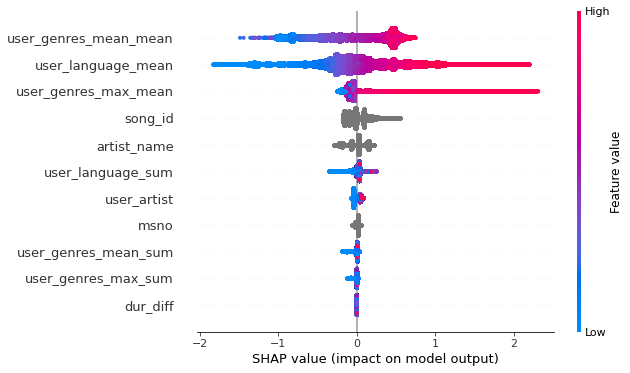

In [ ]:
shap.summary_plot(shap_values, train_features.drop(['target'], axis='columns'))

In [ ]:
del model
del shap_values, explainer

Выкинем несколько фичей и посмотрим на качество

In [ ]:
useless_features = ['dur_diff', 'user_genres_max_sum', 'user_genres_mean_sum', 'msno', 'user_artist']
model = train_model(train_features.drop(useless_features, axis=1), test_features.drop(useless_features, axis=1), cat_features=[0, 1])

0:	test: 0.7634538	test1: 0.7012907	best: 0.7012907 (0)	total: 1.87s	remaining: 3m 4s
10:	test: 0.7756558	test1: 0.7092388	best: 0.7092388 (10)	total: 16.6s	remaining: 2m 14s
20:	test: 0.7775649	test1: 0.7101346	best: 0.7103385 (15)	total: 32.3s	remaining: 2m 1s
30:	test: 0.7819435	test1: 0.7120376	best: 0.7120376 (30)	total: 49.4s	remaining: 1m 50s
40:	test: 0.7836146	test1: 0.7128600	best: 0.7128600 (40)	total: 1m 7s	remaining: 1m 36s
50:	test: 0.7894435	test1: 0.7130339	best: 0.7130339 (50)	total: 1m 25s	remaining: 1m 22s
60:	test: 0.7925785	test1: 0.7129842	best: 0.7130339 (50)	total: 1m 43s	remaining: 1m 6s
70:	test: 0.7944947	test1: 0.7132598	best: 0.7132944 (68)	total: 2m 3s	remaining: 50.3s
80:	test: 0.7955513	test1: 0.7133221	best: 0.7133290 (79)	total: 2m 21s	remaining: 33.2s
90:	test: 0.7963237	test1: 0.7132158	best: 0.7133365 (81)	total: 2m 39s	remaining: 15.8s
99:	test: 0.7969271	test1: 0.7130728	best: 0.7133365 (81)	total: 2m 56s	remaining: 0us

bestTest = 0.7133364586
be

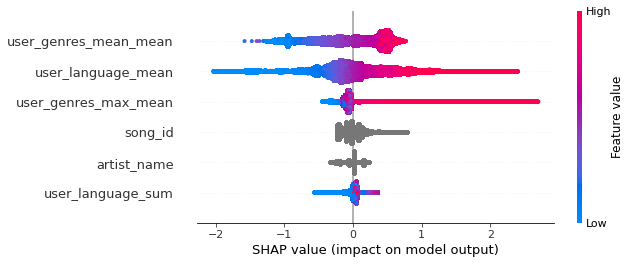

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_features.drop(useless_features + ['target'], axis='columns'))
shap.summary_plot(shap_values, train_features.drop(useless_features + ['target'], axis='columns'))

In [ ]:
del model
del shap_values, explainer

Выкинем все кроме 3х фичей и попробуем поучить на `xgboost`'е, так как категориальных фичей не осталось

In [60]:
useless_features = ['dur_diff', 'user_genres_max_sum', 'user_genres_mean_sum', 'msno', 'user_artist', 'user_language_sum', 'artist_name', 'song_id']

dtrain = xgb.DMatrix(train_features.drop(useless_features + ['target'], axis='columns'), label=train_features.target)
dval = xgb.DMatrix(test_features.drop(useless_features + ['target'], axis='columns'), label=test_features.target)

param = {'max_depth': 6, 'eta': 0.03, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'exact'}
evallist = [(dtrain, 'train'), (dval, 'eval')]

num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=5)

[0]	train-auc:0.776803	eval-auc:0.706938
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[5]	train-auc:0.778824	eval-auc:0.708353
[10]	train-auc:0.779104	eval-auc:0.708648
[15]	train-auc:0.779294	eval-auc:0.708816
[20]	train-auc:0.779413	eval-auc:0.708812
[25]	train-auc:0.779487	eval-auc:0.708861
[30]	train-auc:0.77955	eval-auc:0.708875
[35]	train-auc:0.779628	eval-auc:0.708928
[40]	train-auc:0.779699	eval-auc:0.708967
[45]	train-auc:0.779748	eval-auc:0.708997
[49]	train-auc:0.779799	eval-auc:0.709047


Обучим модель с кросвалидацией

In [116]:
train_features.drop(useless_features, axis='columns')

,target,user_language_mean,user_genres_mean_mean,user_genres_max_mean
1475461,1,0.571429,0.364238,0.364238
1475462,1,0.570048,0.562500,0.562500
1475463,0,0.475000,0.486772,0.486772
1475464,1,0.388889,0.227848,0.227848
1475465,1,0.588235,0.665714,0.665714
...,...,...,...,...
7377299,0,0.172000,0.000000,0.000000
7377300,0,0.172000,0.000000,0.000000
7377301,0,0.614555,0.655172,0.655172
7377302,1,0.197260,0.227273,0.227273


In [117]:
k = 5
kf = KFold(n_splits=k)
mean_auc = 0
for train_index, val_index in kf.split(df):
  train_df = df.iloc[train_index].copy()
  test_df = df.iloc[val_index].copy()
  
  user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob = make_features(train_df)
  train_features = transform_features(train_df, user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob)
  test_features = transform_features(test_df, user_genres_pos, user_genres_mean, user_language_sum, user_language_mean, mean_dur_of_pos_songs, user_artist_prob)
  
  model = train_model(train_features.drop(useless_features, axis='columns'), test_features.drop(useless_features, axis='columns'), cat_features=[], verbose=False)
  preds_proba = model.predict_proba(test_features.drop(useless_features + ['target'], axis='columns'))
  roc_auc = roc_auc_score(test_features.target, preds_proba[:, 1])
  mean_auc += roc_auc

mean_auc / k

0.7102618565475094

Так выглядит датасет со всеми фичами

In [ ]:
train_features.head()

,msno,song_id,target,artist_name,user_language_sum,user_language_mean,user_genres_mean_sum,user_genres_mean_mean,user_genres_max_sum,user_genres_max_mean,dur_diff,user_artist
1475461,gom65a1dZKvlju6YFEXmKMUf9auE+HFVTcdqEpxbhKk=,hlvBIa3DezeYB7hJUopt/gmKf/c4BCCRoLgAxwuiqfU=,1,詹雅雯,100,0.571429,110.0,0.364238,110,0.364238,50183.432584,0.096189
1475462,FCj2jHyeiv7bQF/QbMiOyzgBVtZLZtMPHZ4LBDl8BzU=,hlvBIa3DezeYB7hJUopt/gmKf/c4BCCRoLgAxwuiqfU=,1,詹雅雯,118,0.570048,144.0,0.562500,144,0.562500,18789.421320,0.125382
1475463,VfWeKWt5yKJ7ss0dwR4WW1UIKF0iGT+EeUbks+Lmcyk=,hlvBIa3DezeYB7hJUopt/gmKf/c4BCCRoLgAxwuiqfU=,0,詹雅雯,171,0.475000,184.0,0.486772,184,0.486772,52823.385870,0.031579
1475464,xrkIXMaH4LT7uAR/UKaiPWLlW59kwFa2ul8NCm8QGxg=,hlvBIa3DezeYB7hJUopt/gmKf/c4BCCRoLgAxwuiqfU=,1,詹雅雯,7,0.388889,18.0,0.227848,18,0.227848,48530.913043,0.180000
1475465,EomB75Q1zWGpuzsV9s/57nW1tNltsNpG5x1M4oMCgyA=,hlvBIa3DezeYB7hJUopt/gmKf/c4BCCRoLgAxwuiqfU=,1,詹雅雯,10,0.588235,233.0,0.665714,233,0.665714,43965.658610,0.017575


### Задание 2

In [24]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch

In [25]:
mnso_idx = {msno: idx for idx, msno in enumerate(train_df.msno.unique())}
idx_mnso = {idx: msno for msno, idx in mnso_idx.items()}

In [26]:
song_idx = {song_id: idx for idx, song_id in enumerate(train_df.song_id.unique())}
idx_song = {idx: song_id for song_id, idx in enumerate(song_idx.items())}

'Предложения' на которых будем учить выглядят примерно так

In [27]:
sentences = train_df[train_df.target == 1].groupby('msno').song_id.apply(list)
sentences

msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    [78w25Ysgx+7z9JWQwlA3ypIpPvKBz6afDGLnp1OZUcw=,...
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=    [Hl6EBpUuCKh8k8Mzao5hml03O4q0syx+7atSC3vEvok=,...
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=    [8Q0I8o45d/4HmZKoF/A1114QSYnfxKDTiTgBImebid8=,...
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=       [ED0r/aTepU2vXuPolSKoLObTpKsA8P9y8TOLER1Ao8M=]
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=    [9kvPtsVoRFyh96q8Sk+UiMAPPTaeVvwUAjAUXgpj9NM=,...
                                                                      ...                        
zzH8+kEnDu02NMWBPCjio6wOujBZUs7y9o7AWWcvIGo=    [1c7rPmX4d8mtsd8gJ7Bem6j/v5MMQd9g5jrf8sa9+dg=,...
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=    [xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,...
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=    [68oT2N/+gXsxXrsL1qZjE8rGn6/gfUpPZBPU1AwVHfI=,...
zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=    [DKGm2awf1TsLWeXqpDfVVQf5M2qPmcxI9Dwxz+45Qqs=,...
zzzRi5ek1YCKTGn

In [28]:
class SongDataset(Dataset):
  def __init__(self, sentences, song_idx):
    self.sentences = sentences
    self.song_to_idx = song_idx
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, idx):
    return torch.Tensor([self.song_to_idx.get(song_id) for song_id in self.sentences[idx]]).long()

In [29]:
song_dataset = SongDataset(sentences, song_idx)

song_dataloader = DataLoader(song_dataset, batch_size=1, shuffle=True, num_workers=0)

Напишем модель

In [30]:
class W2V(nn.Module):
  def __init__(self, n_songs, embed_size=16, window_size=2, n_neg_sample=7, max_sentence_len=20):
    super(W2V, self).__init__()
    self.v = nn.Embedding(n_songs, embed_size) # senter word
    self.u = nn.Embedding(n_songs, embed_size) # context word
    self.n_songs = n_songs
    self.window_size = window_size
    self.n_neg_sample = n_neg_sample
    self.max_sentence_len = max_sentence_len

  def loss(self, song_idx, context_song):
    neg_samples_idx = torch.Tensor(np.random.choice(self.n_songs, self.n_neg_sample, replace=False)).long().cuda()
    neg_samples = self.u(neg_samples_idx)
    denominator = torch.sum(torch.log(torch.sigmoid(-torch.mv(neg_samples, self.v(song_idx)))))
    return -torch.log(torch.sigmoid(torch.dot(self.v(song_idx), self.u(context_song)))) - denominator

  def forward(self, sentence):
    len_ = min(len(sentence), self.max_sentence_len)
    if len_ == len(sentence):
      sentence_start = 0
    else:
      sentence_start = np.random.randint(0, len(sentence) - len_)
    losses = []
    for i, song_idx in enumerate(sentence[sentence_start: sentence_start + len_]):
      for j in range(max(i - self.window_size, 0), i):
        context_song = sentence[sentence_start + j]
        losses.append(self.loss(song_idx, context_song))
      for j in range(i + 1, min(i + self.window_size + 1, len_)):
        context_song = sentence[sentence_start + j]
        losses.append(self.loss(song_idx, context_song))
    return torch.stack(losses).mean()

Обучим модель

In [63]:
model = W2V(len(song_idx)).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999))
losses = []
verbose_every = 600
n_iters = 12000
start = time.time()

for i, batch in enumerate(song_dataloader):
  if batch.shape[1] <= 1:
    continue
  optimizer.zero_grad()
  loss = model(batch[0].cuda())
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  if i % verbose_every == 0:
    print(f"loss - {np.mean(losses)}, batches finished - {i}, time took - {time.time() - start}")
    start = time.time()
    losses = []
  if i == n_iters:
    break

loss - 14.308470726013184, batches finished - 0, time took - 0.5599398612976074
loss - 13.949803691997863, batches finished - 600, time took - 326.70251655578613
loss - 13.839367778497785, batches finished - 1200, time took - 317.3302321434021
loss - 13.77641807160936, batches finished - 1800, time took - 321.25098848342896
loss - 13.732859399677379, batches finished - 2400, time took - 321.13426089286804
loss - 13.698992053739044, batches finished - 3000, time took - 316.4317808151245
loss - 13.698521654094968, batches finished - 3600, time took - 328.3615839481354
loss - 13.590697183676646, batches finished - 4200, time took - 320.234432220459
loss - 13.721585096947438, batches finished - 4800, time took - 329.225563287735
loss - 13.523150226436622, batches finished - 5400, time took - 330.2186768054962
loss - 13.535064236549296, batches finished - 6000, time took - 325.93213868141174
loss - 13.577930986568097, batches finished - 6600, time took - 336.06593656539917
loss - 13.5056637

In [66]:
model = model.cpu()

In [81]:
def get_song_embed(song, model, missing_values):
  cur_song_idx = song_idx.get(song, None)
  if cur_song_idx is None:
    return missing_values
  return model.v(torch.tensor(cur_song_idx).long()).detach().numpy()

Сделаем эмбединги для пользователей как среднее по песням которые ему понравились

In [82]:
zero_pad = np.zeros(64)
user_embed = train_df[train_df.target == 1].groupby('msno').song_id.apply(lambda x: np.mean([get_song_embed(song, model, zero_pad) for song in x]))
user_embed

msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=    0.002847
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=   -0.012450
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=    0.015446
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=   -0.073882
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=    0.056786
                                                  ...   
zzH8+kEnDu02NMWBPCjio6wOujBZUs7y9o7AWWcvIGo=    0.002661
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=    0.017471
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=    0.012265
zzqc2ja7z10FtSpagYVcAZXg/gPRq7wcDZuNFj+zJSU=   -0.025135
zzzRi5ek1YCKTGns8C77xwAutE05PAPmz8T/pIIQhzE=    0.285123
Name: song_id, Length: 26417, dtype: float64

Добавим новую фичу - похожесть (dot) пользователя и песни

In [96]:
def add_w2v_features(df, model, user_embed):
  rev_index = {index: i for i, index in enumerate(user_embed.index)}
  user_song_corr = []

  start = time.time()
  cnt = 0
  for index, row in df.iterrows():
    msno = row.msno
    song_id = row.song_id

    cur_user_embed = user_embed.iloc[rev_index.get(msno, 0)]
    cur_song_embed = get_song_embed(song_id, model, zero_pad)
    
    user_song_corr.append(np.sum(cur_user_embed * cur_song_embed))
    cnt += 1
  
  df['user_song_corr'] = user_song_corr
  return df

In [ ]:
add_w2v_features(train_df, model, user_embed);
add_w2v_features(test_df, model, user_embed);

In [102]:
w2v_model = model

Обучим с новой фичёй

In [107]:
cat_boost_model = train_model(train_features.drop(useless_features, axis='columns'), test_features.drop(useless_features, axis='columns'), cat_features=[])

0:	test: 0.7629973	test1: 0.7028320	best: 0.7028320 (0)	total: 1.22s	remaining: 2m
10:	test: 0.7751904	test1: 0.7092540	best: 0.7092540 (10)	total: 12.3s	remaining: 1m 39s
20:	test: 0.7774426	test1: 0.7098713	best: 0.7098713 (20)	total: 25.1s	remaining: 1m 34s
30:	test: 0.7780595	test1: 0.7101398	best: 0.7101492 (28)	total: 38.7s	remaining: 1m 26s
40:	test: 0.7785476	test1: 0.7102438	best: 0.7102438 (40)	total: 52.7s	remaining: 1m 15s
50:	test: 0.7789247	test1: 0.7103574	best: 0.7103574 (50)	total: 1m 6s	remaining: 1m 4s
60:	test: 0.7792458	test1: 0.7103438	best: 0.7104184 (55)	total: 1m 21s	remaining: 51.8s
70:	test: 0.7795401	test1: 0.7103495	best: 0.7104184 (55)	total: 1m 35s	remaining: 38.9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7104184335
bestIteration = 55

Shrink model to first 56 iterations.


Прироста нет :(  
посмотрим shap'ы

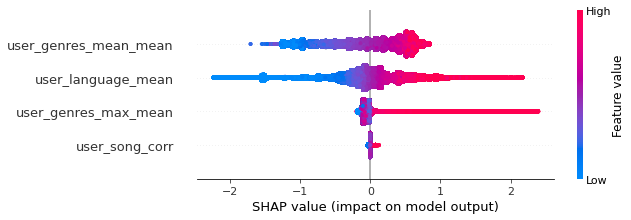

In [108]:
explainer = shap.TreeExplainer(cat_boost_model)
shap_values = explainer.shap_values(train_features.drop(useless_features + ['target'], axis='columns'))
shap.summary_plot(shap_values, train_features.drop(useless_features + ['target'], axis='columns'))

И на них фича выглядит бесполезной :(